# Test results

In [1]:
import numpy as np
import logging
import pickle
import dos

from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]



In [2]:
from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

nw = 30
sim_folder = 'dos/SHWFS_ES'
with open(Path(sim_folder)/'M1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
with open(Path(sim_folder)/'M2.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)

# Function to compute reconstructor error        
def get_rec_error(m1_x0_dt, m2_x0_dt, controllerDT):
    M1Txyz = controllerDT['M1 Txyz'].timeSeries
    M1Rxyz = controllerDT['M1 Rxyz'].timeSeries
    M2Txyz = controllerDT['M2 Txyz'].timeSeries
    M2Rxyz = controllerDT['M2 Rxyz'].timeSeries
    M1BM = controllerDT['M1 BM'].timeSeries

    biasM1Txyz, biasM1Rxyz, biasM1BM = np.zeros((7,3,nw)), np.zeros((7,3,nw)), np.zeros((7,46,nw))
    biasM2Txyz, biasM2Rxyz = np.zeros((7,3,nw)), np.zeros((7,3,nw))

    for kmode in range(3):
        for kseg in range(7):
            biasM1Txyz[kseg,kmode,:] = M1Txyz[1][kseg,kmode,-nw:] + np.array(m1_x0_dt['state']['Txyz'])[kseg,kmode]
            biasM1Rxyz[kseg,kmode,:] = M1Rxyz[1][kseg,kmode,-nw:] + np.array(m1_x0_dt['state']['Rxyz'])[kseg,kmode]
            biasM1BM[kseg,kmode,:] = M1BM[1][kseg,kmode,-nw:] + np.array(m1_x0_dt['state']['modes'])[kseg,kmode]
            biasM2Txyz[kseg,kmode,:] = M2Txyz[1][kseg,kmode,-nw:] + np.array(m2_x0_dt['state']['Txyz'])[kseg,kmode]
            biasM2Rxyz[kseg,kmode,:] = M2Rxyz[1][kseg,kmode,-nw:] + np.array(m2_x0_dt['state']['Rxyz'])[kseg,kmode]
    
    error_mean = [np.linalg.norm(np.reshape(np.mean(biasM1Txyz, axis=2),21),1),
            np.linalg.norm(np.reshape(np.mean(biasM1Rxyz, axis=2),21),1),
            np.linalg.norm(np.reshape(np.mean(biasM1BM, axis=2),7*46),1),
            np.linalg.norm(np.reshape(np.mean(biasM2Txyz, axis=2),21),1),
            np.linalg.norm(np.reshape(np.mean(biasM2Rxyz, axis=2),21),1)]
    error_std = [sum(np.reshape(np.std(biasM1Txyz, axis=2),21)),
            sum(np.reshape(np.std(biasM1Rxyz, axis=2),21)),
            sum(np.reshape(np.std(biasM1BM, axis=2),7*46)),
            sum(np.reshape(np.std(biasM2Txyz, axis=2),21)),
            sum(np.reshape(np.std(biasM2Rxyz, axis=2),21))]
    
    return error_mean, error_std

In [3]:
# Guide star magnitudes to be investigated
mag_values = np.array([6, 8, 10, 12, 14, 16])#, 18, 20, 22])
ctrlK = 0.1

wfe_mean, wfe_std = [], []
pssn_mean, pssn_std = [], []
error_mean, error_std = [], []
#piston = [], []

# List of baseline reconstructor reconstructor
wfe_mean_, wfe_std_ = [], []
pssn_mean_, pssn_std_ = [], []
error_mean_, error_std_ = [], []

n_w = 30

for imag in range(len(mag_values)): 
    #filename = 'dt_mag%d_ctrlK%swoM1S7rot.pickle'% (mag_values[imag],str(ctrlK).replace(".", "p"))
    #filename = 'dt_mag%d_ctrlK%swoM1S7rot_reg7.pickle'% (mag_values[imag],str(ctrlK).replace(".", "p"))
    filename = 'dt_mag%d_ctrlK%swoM1S7rot_reg32.pickle'% (mag_values[imag],str(ctrlK).replace(".", "p"))
    
    with open(Path('testDT')/filename,'rb') as f:
        dt = pickle.load(f)
            
    # WFE
    aux = dt['sim_log_dt']['science']['wfe_rms'].timeSeries[1][-n_w:]*1e9    
    wfe_mean.append(np.mean(aux))
    wfe_std.append(np.std(aux))
    # PSSn
    aux = dt['sim_log_dt']['science']['PSSn'].timeSeries[1][-n_w:]
    pssn_mean.append(np.mean(aux))
    pssn_std.append(np.std(aux))
    # Reconstructor error
    rec_error_mean, rec_error_std = get_rec_error(m1_x0_dt, m2_x0_dt, dt['sim_log_dt']['AcO_controller'])
    error_mean.append(rec_error_mean), error_std.append(rec_error_std)
    
    # Load results using baseline estimator
    filename = 'dt_mag%d_ctrlK%swoM1S7rot_bline.pickle'% (mag_values[imag],
                                                    str(ctrlK).replace(".", "p"))
    
    with open(Path('testDT')/filename,'rb') as f:
        dt = pickle.load(f)
        
    # WFE
    aux = dt['sim_log_dt']['science']['wfe_rms'].timeSeries[1][-n_w:]*1e9    
    wfe_mean_.append(np.mean(aux))
    wfe_std_.append(np.std(aux))
    # PSSn
    aux = dt['sim_log_dt']['science']['PSSn'].timeSeries[1][-n_w:]
    pssn_mean_.append(np.mean(aux))
    pssn_std_.append(np.std(aux))
    # Reconstructor error
    rec_error_mean, rec_error_std = get_rec_error(m1_x0_dt, m2_x0_dt, dt['sim_log_dt']['AcO_controller'])
    error_mean_.append(rec_error_mean), error_std_.append(rec_error_std)
    
if(ctrlK == 0.1):
    wfe_mean0p1, wfe_std0p1, wfe_mean0p1_, wfe_std0p1_ = np.array(wfe_mean), np.array(wfe_std), np.array(wfe_mean_), np.array(wfe_std_)
    pssn_mean0p1, pssn_std0p1, pssn_mean0p1_, pssn_std0p1_ = np.array(pssn_mean), np.array(pssn_std), np.array(pssn_mean_), np.array(pssn_std_)
elif(ctrlK == 0.2):
    wfe_mean0p2, wfe_std0p2, wfe_mean0p2_, wfe_std0p2_ = np.array(wfe_mean), np.array(wfe_std), np.array(wfe_mean_), np.array(wfe_std_)
    pssn_mean0p2, pssn_std0p2, pssn_mean0p2_, pssn_std0p2_ = np.array(pssn_mean), np.array(pssn_std), np.array(pssn_mean_), np.array(pssn_std_)

357.8240540017911 186.19800958376877 33.312154990028375 4.302018172119446
267.7127175350809 85.7776231782768 43.914941016964804 8.604827176400507
362.0533130780738 117.26768769565189 98.97084822796387 22.408382179332076
293.6869279324128 62.246996175264435 231.11584586861986 51.19392603977489
343.8189307776914 102.89138875896113 422.14927447048467 114.92766238074401
825.4817818927526 219.07077192945872 1059.169982416582 357.53388325051066


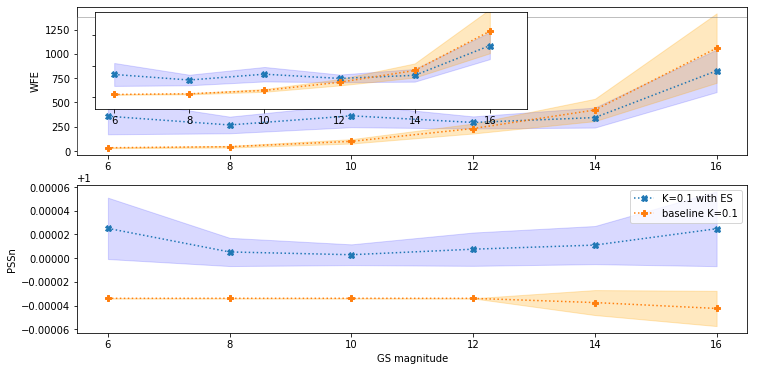

In [6]:
[print(k1,k2,k3,k4) for k1,k2,k3,k4 in zip(wfe_mean0p1,wfe_std0p1,wfe_mean0p1_,wfe_std0p1_)]

plt.figure(figsize=(12,6))
ax1 = plt.subplot(211)
ax1.set_ylabel('WFE')
ax1.plot(mag_values,wfe_mean0p1,'X:', color='tab:blue', label='K=0.1 with ES')
ax1.fill_between(mag_values, wfe_mean0p1-wfe_std0p1, wfe_mean0p1+wfe_std0p1,
    alpha=0.15, edgecolor='blue', facecolor='blue')
#ax1.plot(mag_values,wfe_mean0p2,'P--', color='tab:blue', label='K=0.2 with ES')
ax1.plot(mag_values,wfe_mean0p1_,'P:', color='tab:orange', label='baseline K=0.1')
ax1.fill_between(mag_values, wfe_mean0p1_-wfe_std0p1_, wfe_mean0p1_+wfe_std0p1_,
    alpha=0.25, edgecolor='orange', facecolor='orange')
#ax1.plot(mag_values,wfe_mean0p2_,'P--', color='tab:orange', label='baseline K=0.2')
#ax1.legend()

axins = inset_axes(ax1, 6, 1.35, loc=2, bbox_to_anchor=(0.14,-0.12,1,1), 
                   bbox_transform=ax1.figure.transFigure)
    
axins.plot(mag_values,wfe_mean0p1,'X:', color='tab:blue')
axins.fill_between(mag_values, wfe_mean0p1-wfe_std0p1, wfe_mean0p1+wfe_std0p1,
    alpha=0.15, edgecolor='blue', facecolor='blue')
#axins.plot(mag_values,wfe_mean0p2,'P--', color='tab:blue')
axins.plot(mag_values,wfe_mean0p1_,'P:', color='tab:orange')
axins.fill_between(mag_values, wfe_mean0p1_-wfe_std0p1_, wfe_mean0p1_+wfe_std0p1_,
    alpha=0.25, edgecolor='orange', facecolor='orange')
#axins.plot(mag_values,wfe_mean0p2_,'P--', color='tab:orange')

# Specify the limits
x1, x2, = 5.5, 17
y1 = -200#0.3*min(min(wfe_mean0p1,wfe_mean0p2,wfe_mean0p1_,wfe_mean0p2_))
y2 = 1.3*max(np.hstack([wfe_mean0p1[:6],wfe_mean0p1_[:6],]))

axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
ax1.indicate_inset_zoom(axins)    
# Fix the number of ticks on the inset axes
#plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)


#ax1.tick_params(axis='y')

ax1 = plt.subplot(212)
ax1.set_xlabel('GS magnitude')
ax1.set_ylabel('PSSn')
rec_error_mean, rec_error_mean
ax1.plot(mag_values,pssn_mean0p1,'X:', color='tab:blue', label='K=0.1 with ES')
ax1.fill_between(mag_values, pssn_mean0p1-pssn_std0p1, pssn_mean0p1+pssn_std0p1,
    alpha=0.15, edgecolor='blue', facecolor='blue')
#ax1.plot(mag_values,pssn_mean0p2,'P--', color='tab:blue')
ax1.plot(mag_values,pssn_mean0p1_,'P:', color='tab:orange', label='baseline K=0.1')
ax1.fill_between(mag_values, pssn_mean0p1_-pssn_std0p1_, pssn_mean0p1_+pssn_std0p1_,
    alpha=0.25, edgecolor='orange', facecolor='orange')
#ax1.plot(mag_values,pssn_mean0p2_,'P--', color='tab:orange')
ax1.legend()
ax1.tick_params(axis='y',)


#plt.savefig('wfe_pssn_GSmag.png', format='png', dpi=300, bbox_inches='tight')

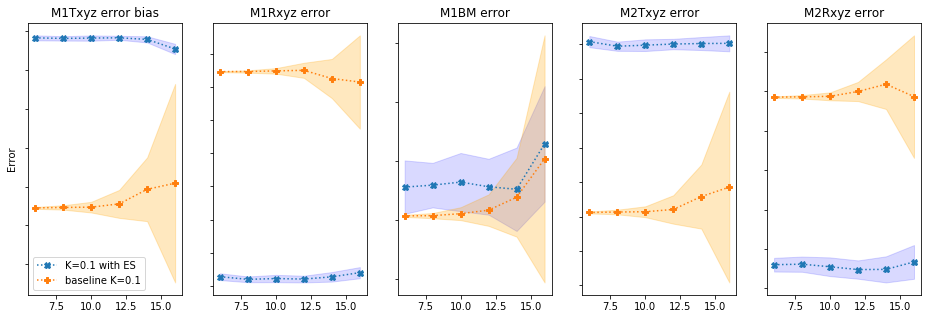

In [7]:
plt.figure(figsize=(16,5))
ax1 = plt.subplot(151)
ax1.set_title('M1Txyz error bias')
ax1.plot(mag_values,np.array(error_mean)[:,0],'X:', color='tab:blue', label='K=0.1 with ES')
ax1.fill_between(mag_values, np.array(error_mean)[:,0]-np.array(error_std)[:,0],
                 np.array(error_mean)[:,0]+np.array(error_std)[:,0],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,0],'P:', color='tab:orange', label='baseline K=0.1')
ax1.fill_between(mag_values, np.array(error_mean_)[:,0]-np.array(error_std_)[:,0],
                 np.array(error_mean_)[:,0]+np.array(error_std_)[:,0],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.legend()
ax1.set_yticklabels([])
ax1.set_ylabel('Error')
ax1 = plt.subplot(152)
ax1.set_title('M1Rxyz error')
ax1.plot(mag_values,np.array(error_mean)[:,1],'X:', color='tab:blue', label='K=0.1 with ES')
ax1.fill_between(mag_values, np.array(error_mean)[:,1]-np.array(error_std)[:,1],
                 np.array(error_mean)[:,1]+np.array(error_std)[:,1],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,1],'P:', color='tab:orange', label='baseline K=0.1')
ax1.fill_between(mag_values, np.array(error_mean_)[:,1]-np.array(error_std_)[:,1],
                 np.array(error_mean_)[:,1]+np.array(error_std_)[:,1],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.set_yticklabels([])
ax1 = plt.subplot(153)
ax1.set_title('M1BM error')
ax1.plot(mag_values,np.array(error_mean)[:,2],'X:', color='tab:blue', label='K=0.1 with ES')
ax1.fill_between(mag_values, np.array(error_mean)[:,2]-np.array(error_std)[:,2],
                 np.array(error_mean)[:,2]+np.array(error_std)[:,2],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,2],'P:', color='tab:orange', label='baseline K=0.1')
ax1.fill_between(mag_values, np.array(error_mean_)[:,2]-np.array(error_std_)[:,2],
                 np.array(error_mean_)[:,2]+np.array(error_std_)[:,2],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.set_yticklabels([])
ax1 = plt.subplot(154)
ax1.set_title('M2Txyz error')
ax1.plot(mag_values,np.array(error_mean)[:,3],'X:', color='tab:blue', label='K=0.1 with ES')
ax1.fill_between(mag_values, np.array(error_mean)[:,3]-np.array(error_std)[:,3],
                 np.array(error_mean)[:,3]+np.array(error_std)[:,3],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,3],'P:', color='tab:orange', label='baseline K=0.1')
ax1.fill_between(mag_values, np.array(error_mean_)[:,3]-np.array(error_std_)[:,3],
                 np.array(error_mean_)[:,3]+np.array(error_std_)[:,3],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.set_yticklabels([])
ax1 = plt.subplot(155)
ax1.set_title('M2Rxyz error')
ax1.plot(mag_values,np.array(error_mean)[:,4],'X:', color='tab:blue', label='K=0.1 with ES')
ax1.fill_between(mag_values, np.array(error_mean)[:,4]-np.array(error_std)[:,4],
                 np.array(error_mean)[:,4]+np.array(error_std)[:,4],
                 alpha=0.15, edgecolor='blue', facecolor='blue')
ax1.plot(mag_values,np.array(error_mean_)[:,4],'P:', color='tab:orange', label='baseline K=0.1')
ax1.fill_between(mag_values, np.array(error_mean_)[:,4]-np.array(error_std_)[:,4],
                 np.array(error_mean_)[:,4]+np.array(error_std_)[:,4],
                 alpha=0.25, edgecolor='orange', facecolor='orange')
ax1.set_yticklabels([])

plt.savefig('recError_GSmag.png', format='png', dpi=300, bbox_inches='tight')

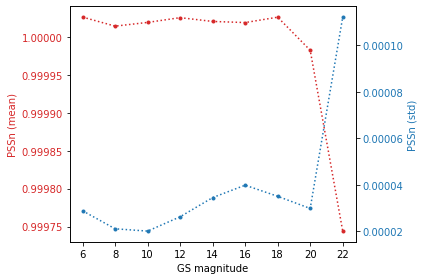

In [86]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('GS magnitude')
ax1.set_ylabel('PSSn (mean)', color=color)
ax1.plot(mag_values,pssn_mean,'.:', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('PSSn (std)', color=color)  # we already handled the x-label with ax1
ax2.plot(mag_values,pssn_std,'.:', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped




In [240]:

filename = 'dt_mag%d_ctrlK%swoM1S7rot_reg32.pickle'% (6,str(0.1).replace(".", "p"))
with open(Path('testDT')/filename,'rb') as f:
    dt = pickle.load(f)

(357.8240540017911, 186.19800958376877)

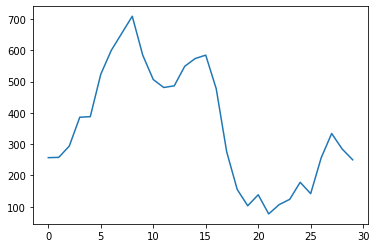

In [241]:
aux = dt['sim_log_dt']['science']['wfe_rms'].timeSeries[1][-n_w:]*1e9  
plt.plot(aux)
np.mean(aux), np.std(aux) 

In [235]:
biasM1Txyz, biasM1Rxyz, biasM1BM, biasM2Txyz, biasM2Rxyz = get_rec_bias(m1_x0_dt, m2_x0_dt, dt['sim_log_dt']['AcO_controller'])
biasM1Txyz, biasM1Rxyz, biasM1BM, biasM2Txyz, biasM2Rxyz        

(-0.00019575989485735482,
 6.117786302295948e-06,
 1.1033940206681803e-06,
 0.0010064456105225953,
 -0.00013346469645251764)

-0.00011511023744853357

In [224]:
x

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[11, 12, 13],
        [14, 15, 16],
        [17, 18, 19]]])

In [223]:
np.reshape(x,(6,3))

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [11, 12, 13],
       [14, 15, 16],
       [17, 18, 19]])